#  Download platform positions

We'll use the `maps.geomar.de` API to obtain positions and time stamps for seagoing platforms.
Results will be stored in: `data/platforms.csv`

In [1]:
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import requests
from time import sleep


KNOWN_PLATFORMS=["AL", "M", "MSM", "SO"]


def get_platform_info(platform: str = "M"):
    """Get current status for platform.
    
    Parameters
    ----------
    platform : str
        Platform ID. Possible values are "SO", "M", "MSM" und AL".
        Defaults to "M".
        
    Returns
    -------
    dict
        "platform": Platform id.
        "leg": Leg info.
        "lon": Longitude.
        "lat": Latitude.
        "time": Time stamp of position.

    """
    try:
        platform_info = requests.get(
            f"https://maps.geomar.de/mapgen_ds/platforms/currentloc?id={platform}",
            timeout=2.0
        ).json()
    except requests.exceptions.Timeout:
        # retry once
        try:
            sleep(3.0)
            platform_info = requests.get(
                f"https://maps.geomar.de/mapgen_ds/platforms/currentloc?id={platform}",
                timeout=4.0
            ).json()
        except requests.exceptions.Timeout:
            return {}
    
    longitude, latitude = platform_info["geometry"]["coordinates"]
    time = datetime.datetime.strptime(
        platform_info["properties"]["data_origin"].split("_")[-1],
        "%Y-%m-%d %H:%M:%S"
    )
    
    return {
        "platform": platform_info["properties"]["platform"],
        "leg": platform_info["properties"]["leg_label"],
        "time": time,
        "latitude": latitude,
        "longitude": longitude,
    }


def get_all_platforms(platforms: list = None):
    if platforms is None:
        platforms = KNOWN_PLATFORMS
    return {
        pfname: get_platform_info(pfname) for pfname in platforms
    }


def get_all_platforms_df(platforms: list = None):
    return pd.DataFrame(get_all_platforms(platforms)).T

In [2]:
platforms = get_all_platforms_df(["AL", "M", "MSM", "SO"])

In [3]:
platforms

,platform,leg,time,latitude,longitude
AL,AL,AL556,2021-05-19 14:19:19,55.4562,15.9044
M,M,NA,2021-05-19 14:15:48,31.8578,-35.3865
MSM,MSM,NA,2021-05-19 14:15:25,55.2592,4.71612
SO,SO,SO283,2021-05-19 14:12:29,46.8655,-7.45723


In [4]:
platforms.to_csv("platforms.csv")

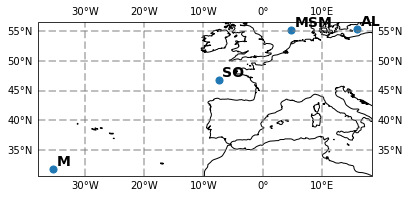

In [5]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree()}
)

platforms.plot.scatter(
    x="longitude", y="latitude", s=50,
    ax=ax, transform=cartopy.crs.PlateCarree()
)
for i, platf in platforms.iterrows():
    ax.annotate(
        platf["platform"],
        (platf["longitude"], platf["latitude"]),
        (platf["longitude"] + 0.6, platf["latitude"] + 0.6),
        transform=cartopy.crs.PlateCarree(),
        fontsize=14, fontweight="bold", color="black"
    )

ax.coastlines()

gl = ax.gridlines(
    crs=cartopy.crs.PlateCarree(), draw_labels=True,
    linewidth=2, color='gray', alpha=0.5, linestyle='--'
)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}